In [1]:
import os
from utils import f1_score_function
from BertClassifier import BertClassifier, init_bert_clf, train_bert_clf, eval_bert_clf
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, accuracy_score
import torch
from torch import nn
import seaborn as sns
import matplotlib.pyplot as plt
import tqdm

/home/giacomo/mambaforge/envs/nlp/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-04-08 01:57:50.074678: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Analyze dataset

In [2]:
texts_df = pd.read_csv('subtaskA_train.csv')

In [3]:
texts_df.head()

,comment_text,conspiratorial
0,⚡Se non ci fossero soldati non ci sarebbero gu...,0
1,"21/08/21]( [PRE-PRINT]\n\n📄__ ""Shedding of Inf...",1
2,PAURA E DELIRIO ALLA CNN: IL MINISTERO DELLA V...,1
3,L'Aspirina non aumenta la sopravvivenza dei pa...,0
4,L'Italia non puo' dare armi lo vieta la Costit...,0


In [4]:
texts_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1845 entries, 0 to 1844
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   comment_text    1842 non-null   object
 1   conspiratorial  1845 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 29.0+ KB


In [5]:
texts_df[texts_df['comment_text'].isna()]

,comment_text,conspiratorial
244,NaN,0
263,NaN,0
665,NaN,0


In [6]:
texts_df = texts_df[texts_df.comment_text.notna()]

In [7]:
texts_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1842 entries, 0 to 1844
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   comment_text    1842 non-null   object
 1   conspiratorial  1842 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 43.2+ KB


In [8]:
texts_df.conspiratorial.value_counts()

1    925
0    917
Name: conspiratorial, dtype: int64

## Preprocessing

Remove break line characthers

In [9]:
texts_df.comment_text = texts_df.comment_text.apply(lambda text: text.replace('\n\n', ' ').replace('\n', ' '))

## Train-Validation split

In [10]:
from sklearn.model_selection import StratifiedShuffleSplit

80-20 train-validation split

In [11]:
# Split the data into training and testing datasets using stratified sampling
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, eval_index in split.split(texts_df, texts_df.conspiratorial):
    train_df, val_df = texts_df.iloc[train_index], texts_df.iloc[eval_index]

In [12]:
print(train_df.info())
print(train_df.conspiratorial.value_counts())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1473 entries, 1512 to 1771
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   comment_text    1473 non-null   object
 1   conspiratorial  1473 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 34.5+ KB
None
1    740
0    733
Name: conspiratorial, dtype: int64


In [13]:
print(val_df.info())
print(val_df.conspiratorial.value_counts())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 369 entries, 363 to 670
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   comment_text    369 non-null    object
 1   conspiratorial  369 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 8.6+ KB
None
1    185
0    184
Name: conspiratorial, dtype: int64


## Tokenization

In [14]:
from transformers import BertTokenizer

In [15]:
tokenizer = BertTokenizer.from_pretrained('dbmdz/bert-base-italian-xxl-cased', do_lower_case=False)

texts_tr = train_df['comment_text']
labels_tr = train_df['conspiratorial'].to_numpy()

In [16]:
texts_tr = train_df['comment_text']
labels_tr = train_df['conspiratorial'].to_numpy()

texts_val = val_df['comment_text']
labels_val = val_df['conspiratorial'].to_numpy()

Observe distribution of tokenized texts lengths by trying a simple tokenization on both tr and val sets.

Token indices sequence length is longer than the specified maximum sequence length for this model (526 > 512). Running this sequence through the model will result in indexing errors


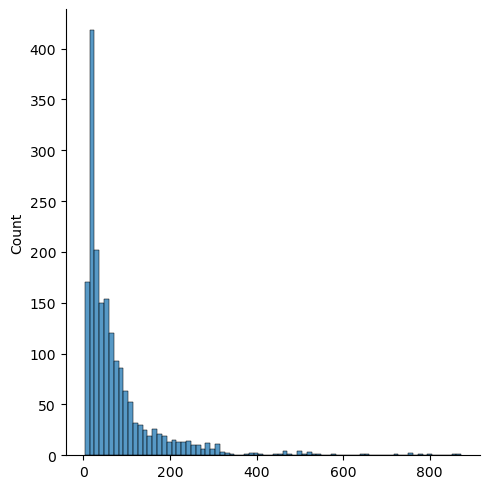

In [17]:
tokenized_len_list = []

for sentence in texts_tr:
    input_ids = tokenizer.encode(sentence, add_special_tokens=True)
    tokenized_len_list.append(len(input_ids))
for sentence in texts_val:
    input_ids = tokenizer.encode(sentence, add_special_tokens=True)
    tokenized_len_list.append(len(input_ids))

sns.displot(tokenized_len_list)
plt.show()

The maximum tokenized length is above the BERT max_lenght limit of 512. Very few texts are above this limit, so we truncate to 512

In [18]:
# Tokenize all of the sentences and map the tokens to thier word IDs.

# Tr set
input_ids_tr = []
attention_masks_tr = []

# `encode_plus` will:
#   1. Tokenize the sentence, 2. Prepend the `[CLS]` token to the start, 3. Append the `[SEP]` token to the end
#   4. Map tokens to their IDs, 5. Pad or truncate the sentence to `max_length`, 6. Create attention masks for [PAD] tokens

for sentence in texts_tr:
    encoded_dict = tokenizer.encode_plus(
                        sentence,
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 512,
                        pad_to_max_length = True,
                        return_attention_mask = True,
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence and attention mask to the list.    
    input_ids_tr.append(encoded_dict['input_ids'])
    attention_masks_tr.append(encoded_dict['attention_mask'])

# Val set
input_ids_val = []
attention_masks_val = []

for sentence in texts_val:
    encoded_dict = tokenizer.encode_plus(
                        sentence,
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 512,
                        pad_to_max_length = True,
                        return_attention_mask = True,
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence and attention mask to the list.    
    input_ids_val.append(encoded_dict['input_ids'])
    attention_masks_val.append(encoded_dict['attention_mask'])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/home/giacomo/mambaforge/envs/nlp/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2304: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [19]:
# Convert the lists into tensors

input_ids_tr = torch.cat(input_ids_tr, dim=0)
input_ids_val = torch.cat(input_ids_val, dim=0)

attention_masks_tr = torch.cat(attention_masks_tr, dim=0)
attention_masks_val = torch.cat(attention_masks_val, dim=0)

labels_tr = torch.tensor(labels_tr)
labels_val = torch.tensor(labels_val)

## Generate DataLoaders

In [20]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

Wrap data into a TensorDataset

In [21]:
tr_dataset = TensorDataset(input_ids_tr, attention_masks_tr, labels_tr)
val_dataset = TensorDataset(input_ids_val, attention_masks_val, labels_val)

The DataLoader needs to know our batch size for training. For fine-tuning BERT on a specific task, the authors recommend a batch size of 16 or 32.

In [22]:
batch_size = 16

Create the DataLoaders for our training and validation sets. Tr samples are taken in random order, while validation are taken sequentially.

In [23]:
tr_dataloader = DataLoader(tr_dataset, sampler=RandomSampler(tr_dataset), batch_size = batch_size)

val_dataloader = DataLoader(val_dataset, sampler=SequentialSampler(val_dataset), batch_size = batch_size)

## Training Grid Search

In [24]:
print(torch.cuda.memory_summary())

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |       0 B  |       0 B  |       0 B  |       0 B  |
|       from large pool |       0 B  |       0 B  |       0 B  |       0 B  |
|       from small pool |       0 B  |       0 B  |       0 B  |       0 B  |
|---------------------------------------------------------------------------|
| Active memory         |       0 B  |       0 B  |       0 B  |       0 B  |
|       from large pool |       0 B  |       0 B  |       0 B  |

Set save folder for this run

In [25]:
from datetime import datetime
curr_date = datetime.now()

print(datetime.now())

save_folder_pth = './bert_subtaskA/{}_{}_{}-{}.{}'.format(curr_date.day, curr_date.month, curr_date.day, curr_date.hour, curr_date.minute)
if not os.path.exists(save_folder_pth):
    os.makedirs(save_folder_pth)

2023-04-08 01:57:53.844599


Fixed general hyperparams

In [26]:
max_epochs = 10


# Num batches*num epochs
tr_steps = len(tr_dataloader)*max_epochs

Variable grid searched hyperparams

In [27]:
lr_list = [0.5e-5, 0.2e-5, 0.8e-5]
warmup_perc_list = [0.1, 0.05] # Percentage of warmup steps for scheduler on the total tr steps
clf_head_list = []

head1 = nn.Sequential(
                nn.Linear(768, 128),
                nn.ReLU(),
                nn.Dropout(0.25),
                nn.Linear(128, 2),
                )
clf_head_list.append((head1, '2_layers_S')) # Each head obeject is composed by a tuple (head, name)

head2 = nn.Sequential(
                nn.Linear(768, 256),
                nn.ReLU(),
                nn.Dropout(0.25),
                nn.Linear(256, 2),
                )
clf_head_list.append((head2, '2_layers_M'))

head3 = nn.Sequential(
                nn.Linear(768, 512),
                nn.ReLU(),
                nn.Dropout(0.3),
                nn.Linear(512, 32),
                nn.ReLU(),
                nn.Dropout(0.2),
                nn.Linear(32, 2),
                )
clf_head_list.append((head3, '3_layers_M'))

Initialize, train/eval and save function for each grid search run

In [28]:
def train_eval_model(lr, warmup_steps, head, model_folder_pth):

    torch.cuda.empty_cache()
    #print(torch.cuda.memory_summary())

    # Initialize model
    bert_clf_model, loss_function, optimizer, scheduler, device = init_bert_clf(tr_steps=tr_steps, lr_rate=lr, scheduler_warmp_steps=warmup_steps, head=head)

    for epoch_i in range(max_epochs):
        print('Epoch: {}'.format(epoch_i))

        # Train
        avg_epoch_loss_tr, acc_score_tr, f1_score_tr, bert_clf_model, optimizer, scheduler = train_bert_clf(bert_clf_model, tr_dataloader, loss_function, optimizer, scheduler, device)


        print('TRAINING | Tr Loss: {} - Tr acc: {} - Tr f1: {}'.format(avg_epoch_loss_tr, acc_score_tr, f1_score_tr))

        # Eval
        avg_epoch_loss_val, acc_score_val, f1_score_val, predictions, labels = eval_bert_clf(bert_clf_model, val_dataloader, loss_function, device)
        print('EVALUATION | Val Loss: {} - Val acc: {} - Val f1: {}'.format(avg_epoch_loss_val, acc_score_val, f1_score_val))

        # Save
        model_save_pth = os.path.join(model_folder_pth, 'bert_clf.pt')
        torch.save({
                    'epoch': epoch_i,
                    'model_state_dict': bert_clf_model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'schdeduler_state_dict': scheduler.state_dict(),
                    'tr_loss': avg_epoch_loss_tr,
                    'val_loss': avg_epoch_loss_val,
                    'tr_acc': acc_score_tr,
                    'val_acc': acc_score_val,
                    'tr_f1': f1_score_tr,
                    'val_f1': f1_score_val,
                    'val_preds': predictions
                    }, model_save_pth)

    torch.cuda.empty_cache()


Grid Search loop

In [29]:
num_trials = len(lr_list) * len(warmup_perc_list) * len(clf_head_list)
print('Executing {} trials in grid search'.format(num_trials))


for lr in lr_list:
    for clf_head_tuple in clf_head_list:
        for warmup_perc in warmup_perc_list:
            
            # Model save path subfolder
            model_folder_str = 'lr{}_warmup{}_head_{}'.format(lr, warmup_perc, clf_head_tuple[1])
            model_folder_pth = os.path.join(save_folder_pth, model_folder_str)
            if not os.path.exists(model_folder_pth):
                os.makedirs(model_folder_pth)

            print('Executing model with lr={}, warmup perc.={}, head={}'.format(lr, warmup_perc, clf_head_tuple[1]))

            train_eval_model(lr, warmup_steps=warmup_perc*tr_steps, head=clf_head_tuple[0], model_folder_pth=model_folder_pth)

           

Executing 18 trials in grid search
Executing model with lr=5e-06, warmup perc.=0.1, head=2_layers_S


Some weights of the model checkpoint at dbmdz/bert-base-italian-xxl-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/home/giacomo/mambaforge/envs/nlp/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarn

There are 1 GPU(s) available.
Device name: NVIDIA GeForce RTX 3080 Ti Laptop GPU
Epoch: 0
TRAINING | Tr Loss: 0.6616752782175618 - Tr acc: 0.6021724372029871 - Tr f1: 0.5999004360788502
EVALUATION | Val Loss: 0.5829866540928682 - Val acc: 0.7262872628726287 - Val f1: 0.7249215780344689
Epoch: 1
TRAINING | Tr Loss: 0.5115685986895715 - Tr acc: 0.7549219280380176 - Tr f1: 0.7541968882218099
EVALUATION | Val Loss: 0.46587145204345387 - Val acc: 0.7994579945799458 - Val f1: 0.798675828712988
Epoch: 2
TRAINING | Tr Loss: 0.37058374205584166 - Tr acc: 0.8397827562797013 - Tr f1: 0.8394096516449483
EVALUATION | Val Loss: 0.4368150470157464 - Val acc: 0.7940379403794038 - Val f1: 0.7940243257535696
Epoch: 3
TRAINING | Tr Loss: 0.24544560104127852 - Tr acc: 0.9110658520027155 - Tr f1: 0.9110066250515961
EVALUATION | Val Loss: 0.5261425226926804 - Val acc: 0.7994579945799458 - Val f1: 0.7982116464676323
Epoch: 4
TRAINING | Tr Loss: 0.1570727543164325 - Tr acc: 0.955193482688391 - Tr f1: 0.955192

Some weights of the model checkpoint at dbmdz/bert-base-italian-xxl-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/home/giacomo/mambaforge/envs/nlp/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarn

There are 1 GPU(s) available.
Device name: NVIDIA GeForce RTX 3080 Ti Laptop GPU
Epoch: 0
TRAINING | Tr Loss: 0.6017272328176806 - Tr acc: 0.6639511201629328 - Tr f1: 0.6618540416728309
EVALUATION | Val Loss: 0.5148275730510553 - Val acc: 0.7425474254742548 - Val f1: 0.7420624701077958
Epoch: 1
TRAINING | Tr Loss: 0.42955559964782447 - Tr acc: 0.7976917854718262 - Tr f1: 0.7975192353820322
EVALUATION | Val Loss: 0.4474239870905876 - Val acc: 0.7831978319783198 - Val f1: 0.7830049985298442
Epoch: 2
TRAINING | Tr Loss: 0.2898616098187944 - Tr acc: 0.8825526137135098 - Tr f1: 0.8825309577293255
EVALUATION | Val Loss: 0.45569646389534074 - Val acc: 0.8211382113821138 - Val f1: 0.8208421610169492
Epoch: 3
TRAINING | Tr Loss: 0.20136663739279073 - Tr acc: 0.9266802443991853 - Tr f1: 0.9266653390421189
EVALUATION | Val Loss: 0.5214527218292156 - Val acc: 0.7967479674796748 - Val f1: 0.7965985844584414
Epoch: 4
TRAINING | Tr Loss: 0.15004650847886197 - Tr acc: 0.9606245756958588 - Tr f1: 0.960

Some weights of the model checkpoint at dbmdz/bert-base-italian-xxl-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/home/giacomo/mambaforge/envs/nlp/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarn

There are 1 GPU(s) available.
Device name: NVIDIA GeForce RTX 3080 Ti Laptop GPU
Epoch: 0
TRAINING | Tr Loss: 0.6488303891433183 - Tr acc: 0.6272912423625254 - Tr f1: 0.6143333576557745
EVALUATION | Val Loss: 0.5751154298583666 - Val acc: 0.7046070460704607 - Val f1: 0.702896356101849
Epoch: 1
TRAINING | Tr Loss: 0.5482894451387467 - Tr acc: 0.736591989137814 - Tr f1: 0.7363235402672177
EVALUATION | Val Loss: 0.49888673176368076 - Val acc: 0.7669376693766937 - Val f1: 0.7666480381198895
Epoch: 2
TRAINING | Tr Loss: 0.435359797971223 - Tr acc: 0.7983706720977597 - Tr f1: 0.7981906021469762
EVALUATION | Val Loss: 0.46970086358487606 - Val acc: 0.7777777777777778 - Val f1: 0.7776455026455027
Epoch: 3
TRAINING | Tr Loss: 0.3317755988688879 - Tr acc: 0.8587915818058385 - Tr f1: 0.8586085319254979
EVALUATION | Val Loss: 0.5240543633699417 - Val acc: 0.7642276422764228 - Val f1: 0.7586694230407818
Epoch: 4
TRAINING | Tr Loss: 0.2581474572740575 - Tr acc: 0.8995247793618466 - Tr f1: 0.89949100

Some weights of the model checkpoint at dbmdz/bert-base-italian-xxl-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/home/giacomo/mambaforge/envs/nlp/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarn

There are 1 GPU(s) available.
Device name: NVIDIA GeForce RTX 3080 Ti Laptop GPU
Epoch: 0
TRAINING | Tr Loss: 0.6051030953725179 - Tr acc: 0.6632722335369993 - Tr f1: 0.6590977808469737
EVALUATION | Val Loss: 0.5523378998041153 - Val acc: 0.7289972899728997 - Val f1: 0.7213832678948958
Epoch: 1
TRAINING | Tr Loss: 0.46005498962376706 - Tr acc: 0.7841140529531568 - Tr f1: 0.7835529161260272
EVALUATION | Val Loss: 0.44878147915005684 - Val acc: 0.7967479674796748 - Val f1: 0.7965985844584414
Epoch: 2
TRAINING | Tr Loss: 0.3464493165093084 - Tr acc: 0.845213849287169 - Tr f1: 0.8451052666533838
EVALUATION | Val Loss: 0.4513953433682521 - Val acc: 0.7940379403794038 - Val f1: 0.7929292929292928
Epoch: 3
TRAINING | Tr Loss: 0.21390960910307463 - Tr acc: 0.923285811269518 - Tr f1: 0.923261902775082
EVALUATION | Val Loss: 0.6190054041023055 - Val acc: 0.7669376693766937 - Val f1: 0.7630942427138079
Epoch: 4
TRAINING | Tr Loss: 0.14591799143661735 - Tr acc: 0.9490835030549898 - Tr f1: 0.949082

Some weights of the model checkpoint at dbmdz/bert-base-italian-xxl-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/home/giacomo/mambaforge/envs/nlp/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarn

There are 1 GPU(s) available.
Device name: NVIDIA GeForce RTX 3080 Ti Laptop GPU
Epoch: 0
TRAINING | Tr Loss: 0.6808151320744587 - Tr acc: 0.5621181262729125 - Tr f1: 0.4868934610692292
EVALUATION | Val Loss: 0.6451592122515043 - Val acc: 0.6531165311653117 - Val f1: 0.6440156768164004
Epoch: 1
TRAINING | Tr Loss: 0.5956822845243639 - Tr acc: 0.7114731839782756 - Tr f1: 0.7092778909092597
EVALUATION | Val Loss: 0.5666727051138878 - Val acc: 0.7398373983739838 - Val f1: 0.7351674641148325
Epoch: 2
TRAINING | Tr Loss: 0.5216889525613477 - Tr acc: 0.790224032586558 - Tr f1: 0.7900192515914972
EVALUATION | Val Loss: 0.5326383275290331 - Val acc: 0.7615176151761518 - Val f1: 0.7615018508725542
Epoch: 3
TRAINING | Tr Loss: 0.409321070839 - Tr acc: 0.8445349626612356 - Tr f1: 0.8445002754414555
EVALUATION | Val Loss: 0.5087714232504368 - Val acc: 0.7831978319783198 - Val f1: 0.7823522472572846
Epoch: 4
TRAINING | Tr Loss: 0.338710028958577 - Tr acc: 0.8778004073319755 - Tr f1: 0.8777958452246

Some weights of the model checkpoint at dbmdz/bert-base-italian-xxl-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/home/giacomo/mambaforge/envs/nlp/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarn

There are 1 GPU(s) available.
Device name: NVIDIA GeForce RTX 3080 Ti Laptop GPU
Epoch: 0
TRAINING | Tr Loss: 0.6066545177531498 - Tr acc: 0.6802443991853361 - Tr f1: 0.6760301750404505
EVALUATION | Val Loss: 0.5265903249382973 - Val acc: 0.7398373983739838 - Val f1: 0.7397437404490419
Epoch: 1
TRAINING | Tr Loss: 0.48219339277154655 - Tr acc: 0.7718940936863544 - Tr f1: 0.7717340771734078
EVALUATION | Val Loss: 0.46440625935792923 - Val acc: 0.7913279132791328 - Val f1: 0.7895411281063665
Epoch: 2
TRAINING | Tr Loss: 0.3370569882694111 - Tr acc: 0.869653767820774 - Tr f1: 0.8696436143734214
EVALUATION | Val Loss: 0.48843745825191337 - Val acc: 0.8048780487804879 - Val f1: 0.804876615746181
Epoch: 3
TRAINING | Tr Loss: 0.23864915762697497 - Tr acc: 0.9164969450101833 - Tr f1: 0.9164870915655554
EVALUATION | Val Loss: 0.5457796386132637 - Val acc: 0.7913279132791328 - Val f1: 0.7910271025631597
Epoch: 4
TRAINING | Tr Loss: 0.1612239817297587 - Tr acc: 0.9497623896809233 - Tr f1: 0.94975

Some weights of the model checkpoint at dbmdz/bert-base-italian-xxl-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/home/giacomo/mambaforge/envs/nlp/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarn

There are 1 GPU(s) available.
Device name: NVIDIA GeForce RTX 3080 Ti Laptop GPU
Epoch: 0
TRAINING | Tr Loss: 0.6408054081983464 - Tr acc: 0.6374745417515275 - Tr f1: 0.633624415909616
EVALUATION | Val Loss: 0.5989057185749213 - Val acc: 0.6639566395663956 - Val f1: 0.6563213556062973
Epoch: 1
TRAINING | Tr Loss: 0.5388336210481582 - Tr acc: 0.7277664630006789 - Tr f1: 0.7274001032853319
EVALUATION | Val Loss: 0.5069984166572491 - Val acc: 0.7615176151761518 - Val f1: 0.7614317620782884
Epoch: 2
TRAINING | Tr Loss: 0.4580212648837797 - Tr acc: 0.7983706720977597 - Tr f1: 0.7979893176729389
EVALUATION | Val Loss: 0.47743623207012814 - Val acc: 0.7506775067750677 - Val f1: 0.7503676686863934
Epoch: 3
TRAINING | Tr Loss: 0.39168602380380835 - Tr acc: 0.8282416836388323 - Tr f1: 0.8281019296898243
EVALUATION | Val Loss: 0.45547330503662425 - Val acc: 0.7804878048780488 - Val f1: 0.7795552605376701
Epoch: 4
TRAINING | Tr Loss: 0.3520564102036979 - Tr acc: 0.8499660556687033 - Tr f1: 0.84976

Some weights of the model checkpoint at dbmdz/bert-base-italian-xxl-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/home/giacomo/mambaforge/envs/nlp/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarn

There are 1 GPU(s) available.
Device name: NVIDIA GeForce RTX 3080 Ti Laptop GPU
Epoch: 0
TRAINING | Tr Loss: 0.6082942405695556 - Tr acc: 0.6632722335369993 - Tr f1: 0.6620934620934622
EVALUATION | Val Loss: 0.5611675195395947 - Val acc: 0.7452574525745257 - Val f1: 0.7434467455621301
Epoch: 1
TRAINING | Tr Loss: 0.48573745386574857 - Tr acc: 0.7549219280380176 - Tr f1: 0.7542327877262675
EVALUATION | Val Loss: 0.47680577139059704 - Val acc: 0.7560975609756098 - Val f1: 0.7560527707586531
Epoch: 2
TRAINING | Tr Loss: 0.41228174995030126 - Tr acc: 0.8078750848608283 - Tr f1: 0.8077035030558729
EVALUATION | Val Loss: 0.46235685236752033 - Val acc: 0.7777777777777778 - Val f1: 0.7776455026455027
Epoch: 3
TRAINING | Tr Loss: 0.3614129537856707 - Tr acc: 0.856754921928038 - Tr f1: 0.8566269934444848
EVALUATION | Val Loss: 0.4581067804247141 - Val acc: 0.7994579945799458 - Val f1: 0.798675828712988
Epoch: 4
TRAINING | Tr Loss: 0.31140357800709306 - Tr acc: 0.8730482009504412 - Tr f1: 0.8729

Some weights of the model checkpoint at dbmdz/bert-base-italian-xxl-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/home/giacomo/mambaforge/envs/nlp/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarn

There are 1 GPU(s) available.
Device name: NVIDIA GeForce RTX 3080 Ti Laptop GPU
Epoch: 0
TRAINING | Tr Loss: 0.6319744612580986 - Tr acc: 0.6503733876442634 - Tr f1: 0.6440715183551173
EVALUATION | Val Loss: 0.5506761173407236 - Val acc: 0.7100271002710027 - Val f1: 0.7083477991091545
Epoch: 1
TRAINING | Tr Loss: 0.5353151857852936 - Tr acc: 0.736591989137814 - Tr f1: 0.7361394787092199
EVALUATION | Val Loss: 0.5017911562075218 - Val acc: 0.7371273712737128 - Val f1: 0.7371273712737128
Epoch: 2
TRAINING | Tr Loss: 0.4682052122649326 - Tr acc: 0.7909029192124916 - Tr f1: 0.7903880983182406
EVALUATION | Val Loss: 0.4639445810268323 - Val acc: 0.7777777777777778 - Val f1: 0.7773051106924165
Epoch: 3
TRAINING | Tr Loss: 0.39259881902766486 - Tr acc: 0.8221317040054311 - Tr f1: 0.8219799988929276
EVALUATION | Val Loss: 0.45114788226783276 - Val acc: 0.7913279132791328 - Val f1: 0.7908301861790235
Epoch: 4
TRAINING | Tr Loss: 0.341961658850152 - Tr acc: 0.8479293957909029 - Tr f1: 0.8478434

Some weights of the model checkpoint at dbmdz/bert-base-italian-xxl-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/home/giacomo/mambaforge/envs/nlp/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarn

There are 1 GPU(s) available.
Device name: NVIDIA GeForce RTX 3080 Ti Laptop GPU
Epoch: 0
TRAINING | Tr Loss: 0.5949939136864036 - Tr acc: 0.6856754921928038 - Tr f1: 0.6846003830122372
EVALUATION | Val Loss: 0.5769261618455251 - Val acc: 0.7452574525745257 - Val f1: 0.7406848086124402
Epoch: 1
TRAINING | Tr Loss: 0.4983823943522669 - Tr acc: 0.7644263408010862 - Tr f1: 0.7637975501316341
EVALUATION | Val Loss: 0.4851665465782086 - Val acc: 0.7696476964769647 - Val f1: 0.7693156326995918
Epoch: 2
TRAINING | Tr Loss: 0.4298747992243177 - Tr acc: 0.7970128988458928 - Tr f1: 0.7967397278860704
EVALUATION | Val Loss: 0.4601282713313897 - Val acc: 0.7967479674796748 - Val f1: 0.7965327863428837
Epoch: 3
TRAINING | Tr Loss: 0.3756472900990517 - Tr acc: 0.8329938900203666 - Tr f1: 0.8328088780286141
EVALUATION | Val Loss: 0.44553081567088765 - Val acc: 0.7831978319783198 - Val f1: 0.783119783707535
Epoch: 4
TRAINING | Tr Loss: 0.3318750740139074 - Tr acc: 0.8560760353021045 - Tr f1: 0.8560467

Some weights of the model checkpoint at dbmdz/bert-base-italian-xxl-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/home/giacomo/mambaforge/envs/nlp/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarn

There are 1 GPU(s) available.
Device name: NVIDIA GeForce RTX 3080 Ti Laptop GPU
Epoch: 0
TRAINING | Tr Loss: 0.6451616873664241 - Tr acc: 0.6286490156143923 - Tr f1: 0.6253607571541161
EVALUATION | Val Loss: 0.5809062744180361 - Val acc: 0.6883468834688347 - Val f1: 0.688200327707444
Epoch: 1
TRAINING | Tr Loss: 0.5477442491439081 - Tr acc: 0.7399864222674813 - Tr f1: 0.739582664971046
EVALUATION | Val Loss: 0.5221523828804493 - Val acc: 0.7506775067750677 - Val f1: 0.7486673773987207
Epoch: 2
TRAINING | Tr Loss: 0.4632109235371313 - Tr acc: 0.7827562797012899 - Tr f1: 0.7827273397743197
EVALUATION | Val Loss: 0.48669996050496894 - Val acc: 0.7859078590785907 - Val f1: 0.7858826985934113
Epoch: 3
TRAINING | Tr Loss: 0.40482432178912625 - Tr acc: 0.8329938900203666 - Tr f1: 0.8328767350733879
EVALUATION | Val Loss: 0.4806997459381819 - Val acc: 0.7913279132791328 - Val f1: 0.7909348441926346
Epoch: 4
TRAINING | Tr Loss: 0.3638241510557872 - Tr acc: 0.8438560760353021 - Tr f1: 0.8437776

Some weights of the model checkpoint at dbmdz/bert-base-italian-xxl-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/home/giacomo/mambaforge/envs/nlp/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarn

There are 1 GPU(s) available.
Device name: NVIDIA GeForce RTX 3080 Ti Laptop GPU
Epoch: 0
TRAINING | Tr Loss: 0.6109959649783309 - Tr acc: 0.6687033265444671 - Tr f1: 0.6678422109103814
EVALUATION | Val Loss: 0.5231995893021425 - Val acc: 0.7533875338753387 - Val f1: 0.7532715636641513
Epoch: 1
TRAINING | Tr Loss: 0.48996763379984004 - Tr acc: 0.7630685675492193 - Tr f1: 0.7628757844337892
EVALUATION | Val Loss: 0.5186975002288818 - Val acc: 0.7669376693766937 - Val f1: 0.7645705976615824
Epoch: 2
TRAINING | Tr Loss: 0.4209337047030849 - Tr acc: 0.8092328581126952 - Tr f1: 0.8090466333243065
EVALUATION | Val Loss: 0.45685214052597684 - Val acc: 0.8021680216802168 - Val f1: 0.8021622098019198
Epoch: 3
TRAINING | Tr Loss: 0.3583329983295933 - Tr acc: 0.8506449422946368 - Tr f1: 0.8506019075157298
EVALUATION | Val Loss: 0.4526424426585436 - Val acc: 0.8075880758807588 - Val f1: 0.806901685620997
Epoch: 4
TRAINING | Tr Loss: 0.32775799361287905 - Tr acc: 0.8716904276985743 - Tr f1: 0.87160

Some weights of the model checkpoint at dbmdz/bert-base-italian-xxl-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/home/giacomo/mambaforge/envs/nlp/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarn

There are 1 GPU(s) available.
Device name: NVIDIA GeForce RTX 3080 Ti Laptop GPU
Epoch: 0
TRAINING | Tr Loss: 0.5650562051162925 - Tr acc: 0.7026476578411406 - Tr f1: 0.7020675094573827
EVALUATION | Val Loss: 0.47980626362065476 - Val acc: 0.7886178861788617 - Val f1: 0.7869136460554371
Epoch: 1
TRAINING | Tr Loss: 0.3691697504211177 - Tr acc: 0.835030549898167 - Tr f1: 0.8349526560781664
EVALUATION | Val Loss: 0.3988794330507517 - Val acc: 0.8184281842818428 - Val f1: 0.8183801652892562
Epoch: 2
TRAINING | Tr Loss: 0.21030436996971408 - Tr acc: 0.9226069246435845 - Tr f1: 0.9225966147946014
EVALUATION | Val Loss: 0.5430902000516653 - Val acc: 0.7940379403794038 - Val f1: 0.7936970338983051
Epoch: 3
TRAINING | Tr Loss: 0.10280156394677056 - Tr acc: 0.96673455532926 - Tr f1: 0.9667306299732701
EVALUATION | Val Loss: 0.6850464648644751 - Val acc: 0.8021680216802168 - Val f1: 0.8002669336002669
Epoch: 4
TRAINING | Tr Loss: 0.04095021097655458 - Tr acc: 0.9871011541072641 - Tr f1: 0.987099

Some weights of the model checkpoint at dbmdz/bert-base-italian-xxl-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/home/giacomo/mambaforge/envs/nlp/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarn

There are 1 GPU(s) available.
Device name: NVIDIA GeForce RTX 3080 Ti Laptop GPU
Epoch: 0
TRAINING | Tr Loss: 0.5444340784383076 - Tr acc: 0.7155465037338764 - Tr f1: 0.7147466428180224
EVALUATION | Val Loss: 0.4756436236202717 - Val acc: 0.7533875338753387 - Val f1: 0.7487748857183472
Epoch: 1
TRAINING | Tr Loss: 0.3288200384266274 - Tr acc: 0.8492871690427699 - Tr f1: 0.8492715385636533
EVALUATION | Val Loss: 0.43205369512240094 - Val acc: 0.7831978319783198 - Val f1: 0.782736693358455
Epoch: 2
TRAINING | Tr Loss: 0.16890778773093737 - Tr acc: 0.9395790902919212 - Tr f1: 0.9395780877755517
EVALUATION | Val Loss: 0.5235966785500447 - Val acc: 0.8157181571815718 - Val f1: 0.8156518161514048
Epoch: 3
TRAINING | Tr Loss: 0.06010874667234959 - Tr acc: 0.9809911744738629 - Tr f1: 0.9809896937627907
EVALUATION | Val Loss: 0.7760758923056225 - Val acc: 0.8021680216802168 - Val f1: 0.8010223302333483
Epoch: 4
TRAINING | Tr Loss: 0.02004846620125576 - Tr acc: 0.9938900203665988 - Tr f1: 0.9938

Some weights of the model checkpoint at dbmdz/bert-base-italian-xxl-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/home/giacomo/mambaforge/envs/nlp/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarn

There are 1 GPU(s) available.
Device name: NVIDIA GeForce RTX 3080 Ti Laptop GPU
Epoch: 0
TRAINING | Tr Loss: 0.5568879431373971 - Tr acc: 0.6897488119484046 - Tr f1: 0.6886375252372241
EVALUATION | Val Loss: 0.5564392606417338 - Val acc: 0.7452574525745257 - Val f1: 0.741411701556629
Epoch: 1
TRAINING | Tr Loss: 0.4230003589263526 - Tr acc: 0.8092328581126952 - Tr f1: 0.8091058140419733
EVALUATION | Val Loss: 0.42045852914452553 - Val acc: 0.7967479674796748 - Val f1: 0.7966942148760332
Epoch: 2
TRAINING | Tr Loss: 0.22465942659845917 - Tr acc: 0.9192124915139172 - Tr f1: 0.9192051930069742
EVALUATION | Val Loss: 0.48653090589990217 - Val acc: 0.7994579945799458 - Val f1: 0.7980325443786983
Epoch: 3
TRAINING | Tr Loss: 0.10052395984280094 - Tr acc: 0.9680923285811269 - Tr f1: 0.9680920932860706
EVALUATION | Val Loss: 0.8064671144626724 - Val acc: 0.7886178861788617 - Val f1: 0.7857079039847519
Epoch: 4
TRAINING | Tr Loss: 0.05518506639274037 - Tr acc: 0.9803122878479293 - Tr f1: 0.980

Some weights of the model checkpoint at dbmdz/bert-base-italian-xxl-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/home/giacomo/mambaforge/envs/nlp/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarn

There are 1 GPU(s) available.
Device name: NVIDIA GeForce RTX 3080 Ti Laptop GPU
Epoch: 0
TRAINING | Tr Loss: 0.521353700328418 - Tr acc: 0.7406653088934148 - Tr f1: 0.7400613852897046
EVALUATION | Val Loss: 0.4482702699800332 - Val acc: 0.7804878048780488 - Val f1: 0.777321661389458
Epoch: 1
TRAINING | Tr Loss: 0.32147583910214006 - Tr acc: 0.8655804480651731 - Tr f1: 0.8655665073675827
EVALUATION | Val Loss: 0.5017676247904698 - Val acc: 0.7886178861788617 - Val f1: 0.7838150462684774
Epoch: 2
TRAINING | Tr Loss: 0.1431509898612476 - Tr acc: 0.9531568228105907 - Tr f1: 0.9531560455787986
EVALUATION | Val Loss: 0.6368766020362576 - Val acc: 0.8102981029810298 - Val f1: 0.8099841101694916
Epoch: 3
TRAINING | Tr Loss: 0.06592113681460521 - Tr acc: 0.9816700610997964 - Tr f1: 0.9816695204098329
EVALUATION | Val Loss: 0.8441228354349732 - Val acc: 0.8102981029810298 - Val f1: 0.8079268292682926
Epoch: 4
TRAINING | Tr Loss: 0.02144931876588793 - Tr acc: 0.9925322471147319 - Tr f1: 0.992532

Some weights of the model checkpoint at dbmdz/bert-base-italian-xxl-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/home/giacomo/mambaforge/envs/nlp/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarn

There are 1 GPU(s) available.
Device name: NVIDIA GeForce RTX 3080 Ti Laptop GPU
Epoch: 0
TRAINING | Tr Loss: 0.5812395730967163 - Tr acc: 0.6897488119484046 - Tr f1: 0.6896664274027697
EVALUATION | Val Loss: 0.480507114281257 - Val acc: 0.7615176151761518 - Val f1: 0.7595948827292112
Epoch: 1
TRAINING | Tr Loss: 0.3971546790612641 - Tr acc: 0.835030549898167 - Tr f1: 0.8349937420623303
EVALUATION | Val Loss: 0.522576275592049 - Val acc: 0.7479674796747967 - Val f1: 0.7368025463051732
Epoch: 2
TRAINING | Tr Loss: 0.2417513112267179 - Tr acc: 0.9097080787508486 - Tr f1: 0.9097039171213143
EVALUATION | Val Loss: 0.5049116446947058 - Val acc: 0.8048780487804879 - Val f1: 0.8038277511961722
Epoch: 3
TRAINING | Tr Loss: 0.11185683688068743 - Tr acc: 0.9633401221995926 - Tr f1: 0.9633380776619556
EVALUATION | Val Loss: 0.7877497992788752 - Val acc: 0.7859078590785907 - Val f1: 0.7819034722170267
Epoch: 4
TRAINING | Tr Loss: 0.056356537051909475 - Tr acc: 0.9864222674813307 - Tr f1: 0.9864215

Some weights of the model checkpoint at dbmdz/bert-base-italian-xxl-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/home/giacomo/mambaforge/envs/nlp/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarn

There are 1 GPU(s) available.
Device name: NVIDIA GeForce RTX 3080 Ti Laptop GPU
Epoch: 0
TRAINING | Tr Loss: 0.5394223152950246 - Tr acc: 0.7372708757637475 - Tr f1: 0.7370959075951731
EVALUATION | Val Loss: 0.4668655215452115 - Val acc: 0.7886178861788617 - Val f1: 0.7877934410758524
Epoch: 1
TRAINING | Tr Loss: 0.33192866263530585 - Tr acc: 0.8608282416836388 - Tr f1: 0.8608218271418754
EVALUATION | Val Loss: 0.4620110293229421 - Val acc: 0.7859078590785907 - Val f1: 0.7855045804054303
Epoch: 2
TRAINING | Tr Loss: 0.1586220611327438 - Tr acc: 0.9477257298031229 - Tr f1: 0.9477241878354492
EVALUATION | Val Loss: 0.6451182886958122 - Val acc: 0.7886178861788617 - Val f1: 0.7866988794687853
Epoch: 3
TRAINING | Tr Loss: 0.08703274315633681 - Tr acc: 0.9735234215885947 - Tr f1: 0.9735232263437607
EVALUATION | Val Loss: 0.842063651420176 - Val acc: 0.8102981029810298 - Val f1: 0.8102855631940772
Epoch: 4
TRAINING | Tr Loss: 0.035123024228459566 - Tr acc: 0.991174473862865 - Tr f1: 0.99117

## Initialize model

In [30]:
lr_rate = 0.5e-5
scheduler_warmup_step = 0
max_epochs = 12

# Num batches*num epochs
tr_steps = len(tr_dataloader)*max_epochs

In [31]:
bert_clf_model, loss_function, optimizer, scheduler, device = init_bert_clf(tr_steps=tr_steps, lr_rate=lr_rate, scheduler_warmp_steps=scheduler_warmup_step)

Some weights of the model checkpoint at dbmdz/bert-base-italian-xxl-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


There are 1 GPU(s) available.
Device name: NVIDIA GeForce RTX 3080 Ti Laptop GPU


/home/giacomo/mambaforge/envs/nlp/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [32]:
print('Using as device:', device)

Using as device: cuda


In [33]:
torch.cuda.empty_cache()

In [34]:
print(torch.cuda.memory_summary())

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |    6546 KB |   11833 MB |  760866 GB |  760866 GB |
|       from large pool |    4096 KB |   11827 MB |  759221 GB |  759221 GB |
|       from small pool |    2450 KB |      16 MB |    1644 GB |    1644 GB |
|---------------------------------------------------------------------------|
| Active memory         |    6546 KB |   11833 MB |  760866 GB |  760866 GB |
|       from large pool |    4096 KB |   11827 MB |  759221 GB |

## Training

In [35]:
from datetime import datetime
curr_date = datetime.now()

print(datetime.now())

save_folder_pth = './bert_subtaskA/{}_{}_{}-{}.{}'.format(curr_date.day, curr_date.month, curr_date.day, curr_date.hour, curr_date.minute)
if(not os.path.exists(save_folder_pth)):
    os.makedirs(save_folder_pth)

2023-04-08 06:54:58.724348


In [36]:
curr_optimizer = optimizer
curr_scheduler = scheduler
curr_bert_clf = bert_clf_model

In [37]:
for epoch_i in range(max_epochs):
    # Train
    avg_epoch_loss_tr, acc_score_tr, f1_score_tr, model, optimizer, scheduler = train_bert_clf(bert_clf_model, tr_dataloader, loss_function, optimizer, scheduler, device)
    curr_optimizer = optimizer
    curr_scheduler = scheduler
    curr_bert_clf = model
    
    print('Epoch: {}| Tr Loss: {} - Tr acc: {} - Tr f1: {}'.format(epoch_i, avg_epoch_loss_tr, acc_score_tr, f1_score_tr))

    # Eval
    avg_epoch_loss_val, acc_score_val, f1_score_val, predictions, labels = eval_bert_clf(bert_clf_model, val_dataloader, loss_function, device)
    print('EVALUATION | Val Loss: {} - Val acc: {} - Val f1: {}'.format(avg_epoch_loss_val, acc_score_val, f1_score_val))

    # Save
    save_path = os.path.join(save_folder_pth, 'bert_clf.pt')
    torch.save({
                'epoch': epoch_i,
                'model_state_dict': curr_bert_clf.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'schdeduler_state_dict': scheduler.state_dict(),
                'tr_loss': avg_epoch_loss_tr,
                'val_loss': avg_epoch_loss_val,
                'tr_acc': acc_score_tr,
                'val_acc': acc_score_val,
                'tr_f1': f1_score_tr,
                'val_f1': f1_score_val,
                'val_preds': predictions
                }, save_path)

Epoch: 0| Tr Loss: 0.6081453029827405 - Tr acc: 0.6687033265444671 - Tr f1: 0.6687031738540499
EVALUATION | Val Loss: 0.5338722169399261 - Val acc: 0.7235772357723578 - Val f1: 0.7232337196305666
Epoch: 1| Tr Loss: 0.4911935066664091 - Tr acc: 0.7766463000678887 - Tr f1: 0.7763886511300837
EVALUATION | Val Loss: 0.48243209905922413 - Val acc: 0.7560975609756098 - Val f1: 0.7555787800282618
Epoch: 2| Tr Loss: 0.35770584442602693 - Tr acc: 0.8418194161575017 - Tr f1: 0.841735094921868
EVALUATION | Val Loss: 0.5237541813403368 - Val acc: 0.7831978319783198 - Val f1: 0.781449893390192
Epoch: 3| Tr Loss: 0.2988268958945428 - Tr acc: 0.8940936863543788 - Tr f1: 0.8940760627058204
EVALUATION | Val Loss: 0.5829353736092647 - Val acc: 0.7831978319783198 - Val f1: 0.7818504286136565
Epoch: 4| Tr Loss: 0.17743003027393453 - Tr acc: 0.9436524100475221 - Tr f1: 0.9436398378237589
EVALUATION | Val Loss: 0.813459321235617 - Val acc: 0.7669376693766937 - Val f1: 0.763419216317767
Epoch: 5| Tr Loss: 0.